# What is an MLP?

An MLP (Multi-Layer Perceptron) is a type of neural network that learns patterns in data and makes predictions — like classifying someone as a child or adult based on brain activity.

Input Layer → Hidden Layers → Output Layer

Each layer is made up of neurons (just math functions) that:

1. Take input numbers (features)

2. Apply some weights and math

3. Pass them forward through activation functions (like ReLU)

4. Gradually “learn” the right way to make predictions


# 1. Load the Saved Correlation Matrices

In [5]:
import numpy as np
import os

# Directory where correlation matrices are saved
corr_dir = os.path.expanduser("~/correlation_matrices")

# Correlation types
correlation_types = ["correlation", "partial correlation", "tangent"]

# Dictionary to store loaded matrices
correlation_matrices = {}

# Load each correlation matrix file
for kind in correlation_types:
    file_path = os.path.join(corr_dir, f"{kind}_correlation_matrices.npz")
    data = np.load(file_path)
    correlation_matrices[kind] = data["matrices"]
    print(f"{kind}: {correlation_matrices[kind].shape}")


correlation: (155, 39, 39)
partial correlation: (155, 39, 39)
tangent: (155, 39, 39)


- 155 subjets 
- each with a 39x39 correlation matrix (between 39 regions)

# 2. Extract the Upper Triangle (excluding diagonal)

Goal:

- To convert each subject’s 39×39 correlation matrix into a flattened feature vector that only includes unique pairwise connections (no diagonal, no duplicates).



In [6]:
# Get indices for the upper triangle without diagonal

'''
n_nodes = 39 (the number of brain regions).
assuming  all correlation types have the same matrix size (which they do).
'''
n_nodes = correlation_matrices["correlation"].shape[1]

'''
This gets the indices for the upper triangle of a 39×39 matrix
excluding the diagonal.

For 39 nodes, that gives you 741 values (since matrix is symmetrical)
(since 39C2 = 741 unique region-to-region connections).

i.e. How many ways can we choose 2 regions out of 39 to form a connection?
'''
upper_idx = np.triu_indices(n_nodes, k=1)  # k=1 excludes diagonal

# Function to extract upper triangles from a 3D matrix set
'''
Takes a set of correlation matrices 
For each subject, extracts just the upper triangle values
Returns an array of shape (155, 741) — one flattened feature vector per subject.
'''
def extract_upper_triangles(matrix_set):
    b = np.array([matrix[upper_idx] for matrix in matrix_set])
    print(b.shape)
    return b 
# Dictionary to store upper triangle features
'''
Loops over each correlation type
Applies the function to extract the features
Stores the results in upper_triangle_features
'''
upper_triangle_features = {}

for kind in correlation_types:
    upper_triangle_features[kind] = extract_upper_triangles(correlation_matrices[kind])
    print(f"{kind} features shape: {upper_triangle_features[kind].shape}")


(155, 741)
correlation features shape: (155, 741)
(155, 741)
partial correlation features shape: (155, 741)
(155, 741)
tangent features shape: (155, 741)


### 🧠 Why Upper Triangle?
We started with 155 subjects, each with a 39x39 matrix showing how brain regions are connected but this includes a lot of repeated values because the matrices are symmetric.

Also, the diagonal is always 1, which isn't helpful for learning (it's just a region connected to itself)

Now, for 39 brain regions, there are 741 unique pairs. So now each subject is described by 741 numbers (instead of a full 39×39 matrix).

- Shape (155, 741): 
   - 155 people
   - Each person is represented by 741 features (how strongly their brain regions connect)

# 3. Load Labels and Split the Data

Goal:
To load the class labels (child/adult), check the distribution, and split the data into training and testing sets for each type of correlation matrix.


In [7]:
from sklearn.model_selection import train_test_split
import numpy as np
import os

# Load class labels
label_path = os.path.expanduser("~/time_series_data/subject_labels.npy")
labels = np.load(label_path)

# Confirm shape and class balance (shoes how many of each class we have)
print("Labels shape:", labels.shape)
print("Class distribution:", np.unique(labels, return_counts=True))

# empty dictionary to store Train-test split for each correlation type
split_data = {}

'''
For each correlation type:
- x =  741-feature vector per subject from the upper triangle
- y = class labels
- train_test_split(...) splits into:
  - 80% training, 20% testing
  - stratify=y ensures the same class ratio is maintained in both sets
'''
for kind in correlation_types:  # ["correlation", "partial correlation", "tangent"]
    X = upper_triangle_features[kind]
    y = labels

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    split_data[kind] = {
        "X_train": X_train, "X_test": X_test,
        "y_train": y_train, "y_test": y_test
    }

    print(f"{kind} ➤ Train: {X_train.shape}, Test: {X_test.shape}")


Labels shape: (155,)
Class distribution: (array([0, 1]), array([122,  33]))
correlation ➤ Train: (124, 741), Test: (31, 741)
partial correlation ➤ Train: (124, 741), Test: (31, 741)
tangent ➤ Train: (124, 741), Test: (31, 741)


- 155 subjects 
- 122 children (0) and 33 adults (1)
- 124 train samples
- 31 test samples
- 741 features per sample (from upper triangle)

# 4. Train and Evaluate MLP Classifiers

1. mlp = MLPClassifier(**mlp_config):

- is the same as mlp = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42, activation='relu') - default scikit-learn values
- 3 layer neural network:
  - Input layer: Takes in your features (in your case, 741 features per subject)
  - First hidden layer: 64 neurons
  - Second hidden layer: 32 neurons
  - Output layer: Automatically set to 1 neuron (since you're doing binary classification: child vs. adult)
- max_iter=500: the model will train for up to 500 iterations (epochs).
- random_state=42: Sets the random seed so results are reproducible.
- activation='relu'

**Summary** - a neural network with two hidden layers (64 and 32 neurons), using ReLU to activate the neurons, trained for up to 500 iterations with reproducable results. 

2. Learning rate:
- default values:
  - learning_rate='constant'
  - learning_rate_init=0.001
  - The Adam optimizer (default solver) adjusts things internally, but this is our starting rate




🔹 MLP for CORRELATION correlation
              precision    recall  f1-score   support

       Child       0.85      0.96      0.90        24
       Adult       0.75      0.43      0.55         7

    accuracy                           0.84        31
   macro avg       0.80      0.69      0.72        31
weighted avg       0.83      0.84      0.82        31



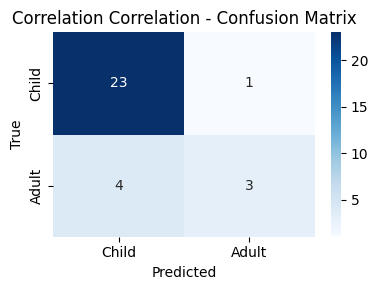


🔹 MLP for PARTIAL CORRELATION correlation
              precision    recall  f1-score   support

       Child       0.82      0.96      0.88        24
       Adult       0.67      0.29      0.40         7

    accuracy                           0.81        31
   macro avg       0.74      0.62      0.64        31
weighted avg       0.79      0.81      0.78        31



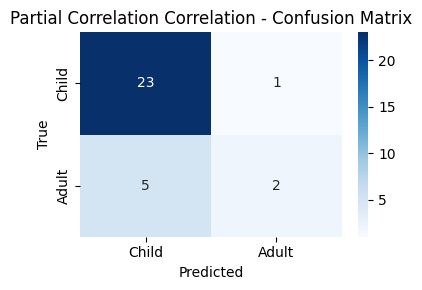


🔹 MLP for TANGENT correlation
              precision    recall  f1-score   support

       Child       0.95      0.83      0.89        24
       Adult       0.60      0.86      0.71         7

    accuracy                           0.84        31
   macro avg       0.78      0.85      0.80        31
weighted avg       0.87      0.84      0.85        31



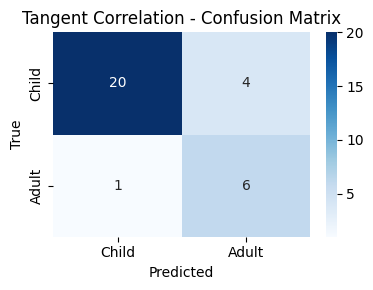

In [8]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Set a consistent MLP config
'''
Defines the architecture and training parameters for the MLP.
Two hidden layers:
 - First with 64 neurons
 - Second with 32 neurons
Trains up to 500 iterations.
Fixed random_state ensures reproducibility
'''
mlp_config = {
    "hidden_layer_sizes": (64, 32),
    "max_iter": 500,
    "random_state": 42
}

# Train and evaluate MLP for each correlation type
for kind in correlation_types:
    print(f"\n🔹 MLP for {kind.upper()} correlation")

    X_train = split_data[kind]["X_train"]
    X_test = split_data[kind]["X_test"]
    y_train = split_data[kind]["y_train"]
    y_test = split_data[kind]["y_test"]

    mlp = MLPClassifier(**mlp_config)
    mlp.fit(X_train, y_train)

    #predicts on test set
    y_pred = mlp.predict(X_test)

    print(classification_report(y_test, y_pred, target_names=["Child", "Adult"]))

    # Confusion matrix (computes how many predictions were correct/incorrect for each class)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Child", "Adult"], yticklabels=["Child", "Adult"])
    plt.title(f"{kind.title()} Correlation - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()


### MLP Classification Results (Using Upper Triangle of Correlation Matrices)

| Correlation Type     | Accuracy | Child Precision | Child Recall | Adult Precision | Adult Recall | Notes                                           |
|----------------------|----------|------------------|---------------|------------------|--------------|-------------------------------------------------|
| Pearson (Correlation)       | 0.84     | 0.85             | 0.96          | 0.75             | 0.43         | High child recall, weak adult recall           |
| Partial Correlation  | 0.81     | 0.82             | 0.96          | 0.67             | 0.29         | Similar to Pearson but worse adult performance |
| Tangent              | 0.84     | 0.95             | 0.83          | 0.60             | 0.86         |  **Best adult recall & most balanced** overall    |


### 🧠 Insights:

- Tangent correlation stands out: it's the only one where adults were well identified (recall 0.86).

- Pearson and Partial both heavily favor predicting "Child", which matches the class imbalance.

- We get similar overall accuracy with Pearson and Tangent, but Tangent is clearly fairer across classes.

## 5. Plot MLP Accuracies

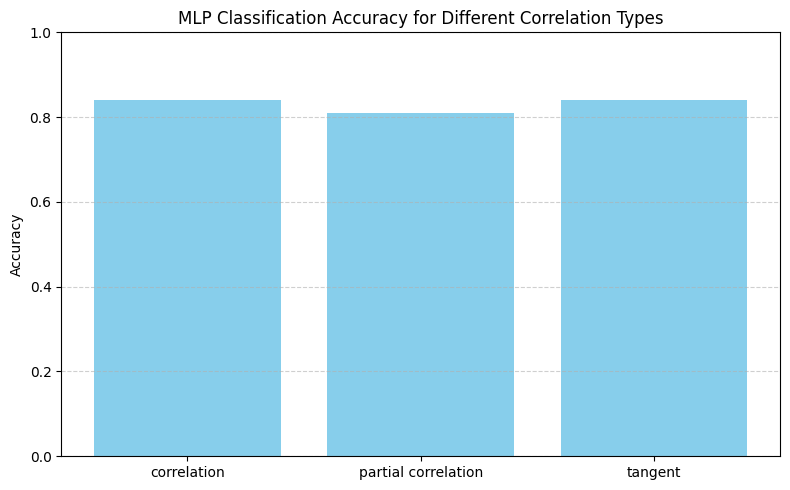

In [9]:
import matplotlib.pyplot as plt

# Accuracy values for MLP from screenshots (based on confusion matrix summaries)
mlp_accuracies = {
    "correlation": 0.84,
    "partial correlation": 0.81,
    "tangent": 0.84
}

# Plotting
plt.figure(figsize=(8, 5))
plt.bar(mlp_accuracies.keys(), mlp_accuracies.values(), color='skyblue')
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("MLP Classification Accuracy for Different Correlation Types")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


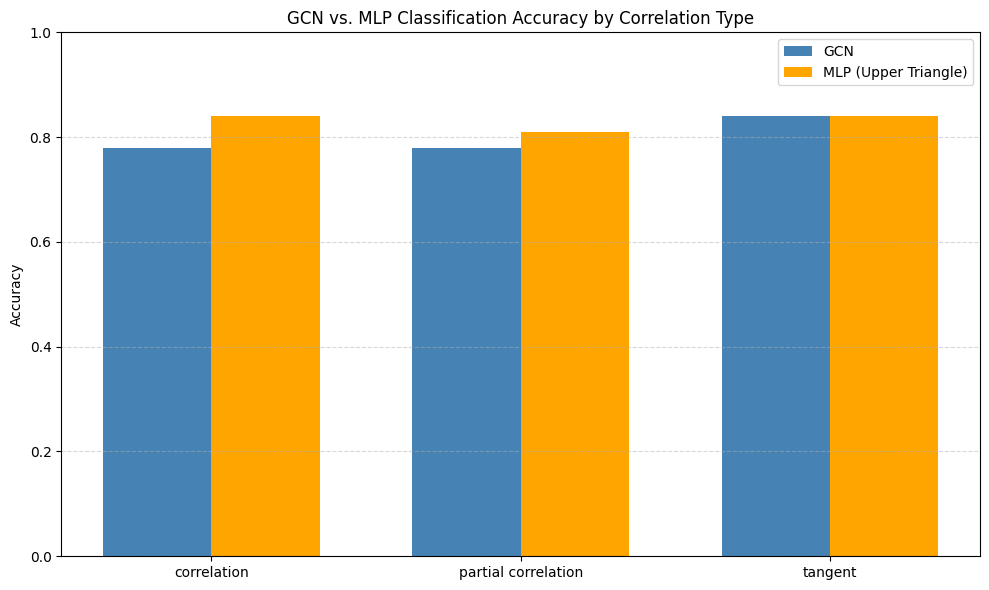

In [10]:
import numpy as np

# GCN accuracy from your bar chart (estimated visually or extracted from file if available)
# Assuming representative best values for each correlation type (averaged or selected from the plot)
gcn_accuracies = {
    "correlation": 0.78,
    "partial correlation": 0.78,
    "tangent": 0.84
}

# Plotting side-by-side comparison
labels = list(mlp_accuracies.keys())
x = np.arange(len(labels))  # Label positions

bar_width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - bar_width/2, [gcn_accuracies[k] for k in labels], width=bar_width, label='GCN', color='steelblue')
plt.bar(x + bar_width/2, [mlp_accuracies[k] for k in labels], width=bar_width, label='MLP (Upper Triangle)', color='orange')

plt.xticks(x, labels)
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("GCN vs. MLP Classification Accuracy by Correlation Type")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


MLP:
- Treats each subject as a flat row of numbers — like a spreadsheet.
- It doesn’t care which brain regions are connected to each other.
- It just learns from the overall pattern of correlations.

GCN:
Thinks of each subject as a graph:
- Nodes = brain regions
- Edges = connections (from your correlation matrix)
- Each node can "talk" to its neighbors and update its information based on them.
- This lets GCN capture relationships between regions — not just their individual values.

In [4]:

a = np.arange(25).reshape(5,5)
print(a)

[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]
 [20 21 22 23 24]]
